In [1]:
import numpy as np
from numpy import linalg as la
import cv2

import matplotlib.pyplot as plt

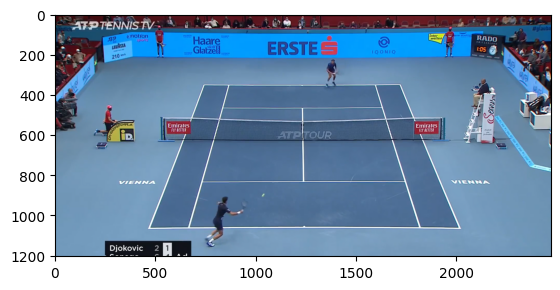

In [2]:
img_path = '/home/suetin/Projects/VSCode/TennisApp/SimpleApp/input_videos/image.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img);

In [3]:
img.shape

(1204, 2471, 3)

In [4]:
2471 / 1204

2.052325581395349

In [5]:
WIDTH = 10.97
HEIGHT = 23.77
RATIO = HEIGHT / WIDTH
RATIO

2.1668185961713764

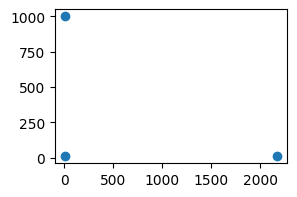

In [6]:
# Court size in pixels
h_cort = 1000 * RATIO
w_cort = 1000

# Specify world coordinates of rectangular license plate
X = np.array([10, 10, h_cort, h_cort])
Y = np.array([10, w_cort, 10, w_cort])

plt.figure(figsize=(3, 2))
plt.scatter(X[:3], Y[:3])

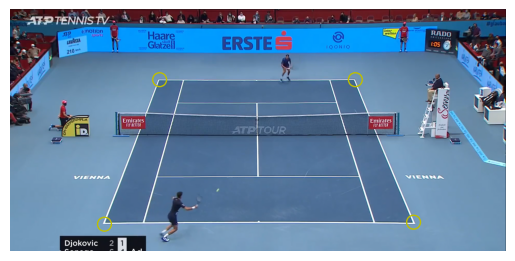

In [7]:
u = np.array([745, 1720, 470, 2010])
v = np.array([350, 350, 1070, 1060])

# Display image with image coordinates 
plt.scatter(u, v, s=100, facecolors= 'none', edgecolors='y')
plt.imshow(img)
plt.axis('off')
plt.show()

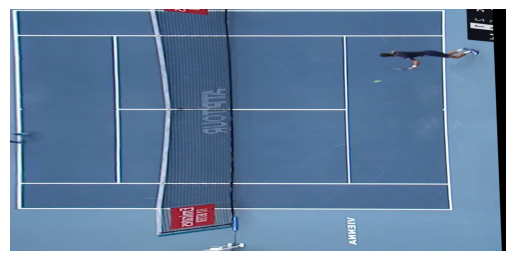

In [8]:
# Estimate homography
A = np.zeros((8, 9))
for i in range(0, 4):
    A[2*i, :] = [ 0, 0, 0, -X[i], Y[i], -1, v[i]*X[i], v[i]*Y[i], v[i] ]
    A[2*i+1, :] = [ X[i], Y[i], 1, 0, 0, 0, -u[i]*X[i], -u[i]*Y[i], -u[i] ]

# total least-squares
L, V = la.eig(A.T @ A)
h = V[:, -1]  # minimial eigenvalue eigenvector
H = np.reshape(h, (3, 3))   # to 3x3 homography
H = la.inv(H)

# Rectify image based on homography
im_warp = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))

# Display rectified image
plt.imshow(im_warp)
# plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [9]:
# BALL DETECTION AFTER USING HOMOGRAPHY MATRIX

### From https://github.com/hgupt3/TRACE/

In [10]:
from numpy import float32, zeros,  uint8, shape, array, squeeze
from cv2 import VideoCapture, getPerspectiveTransform, warpPerspective, line, circle, rectangle, perspectiveTransform


In [11]:
width = int(967)
height = int(1585)

ratio = (1097/2377)
courtHeight = int(height * 0.6)
courtWidth = int(courtHeight * ratio)
yOffset = int((height - courtHeight) / 2)
xOffset = int((width - courtWidth) / 2)

courtTL = [xOffset,yOffset]
courtTR = [courtWidth+xOffset,yOffset]
courtBL = [xOffset,courtHeight+yOffset]
courtBR = [courtWidth+xOffset,courtHeight+yOffset]

In [12]:
def courtMap(frame, top_left, top_right, bottom_left, bottom_right):
    pts1 = float32([[top_left, top_right, bottom_left, bottom_right]])
    pts2 = float32([courtTL, courtTR, courtBL, courtBR])
    M = getPerspectiveTransform(pts1,pts2)
    dst = warpPerspective(frame,M,(width,height))
    return dst, M

def showLines(img_):
    rectangle(frame, (0,0),(width,height),(255,255,255),6)
    rectangle(frame, (xOffset,yOffset), (courtWidth+xOffset,courtHeight+yOffset), (255, 255, 255), 2)
    rectangle(frame, (xOffset,yOffset+int(courtHeight*0.5)), (courtWidth+xOffset,yOffset+int(courtHeight*0.5)), (255, 255, 255), 2)
    rectangle(frame, (xOffset+int(courtWidth*0.124886),yOffset), (courtWidth+xOffset-int(courtWidth*0.124886),courtHeight+yOffset), (255, 255, 255), 2)
    rectangle(frame, (xOffset+int(courtWidth*0.124886),yOffset+int(courtHeight*0.23054)), (courtWidth+xOffset-int(courtWidth*0.124886),courtHeight+yOffset-int(courtHeight*0.23054)), (255, 255, 255), 2)
    rectangle(frame, (xOffset+int(courtWidth*0.5),yOffset+int(courtHeight*0.23054)), (courtWidth+xOffset-int(courtWidth*0.5),courtHeight+yOffset-int(courtHeight*0.23054)), (255, 255, 255), 2)
    return frame

def showPoint(frame, M, point):
    points = float32([[point]])
    transformed = perspectiveTransform(points, M)[0][0]
    circle(frame, (int(transformed[0]), int(transformed[1])), radius=0, color=(0, 0, 255), thickness=25)
    return frame

def givePoint(M, point):
    points = float32([[point]])
    transformed = perspectiveTransform(points, M)[0][0]
    return (int(transformed[0]), int(transformed[1]))

(1585, 967, 3)


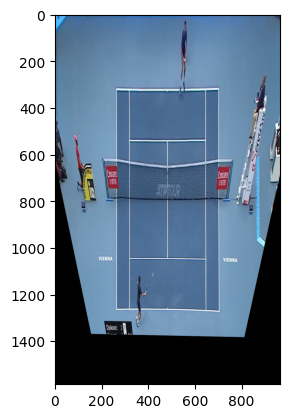

In [60]:
# Distorting frame and outputting results
processedFrame, M = courtMap(img, *list(zip(u, v)))
print(processedFrame.shape)

plt.imshow(processedFrame)

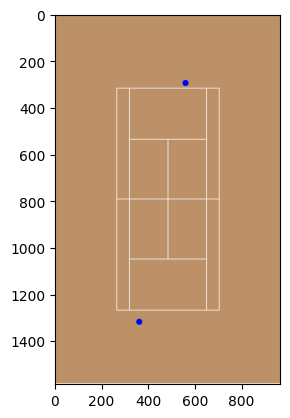

In [61]:
# Create black background
rectangle(processedFrame, (0,0),(967,1585),(188,145,103),2000)
processedFrame = showLines(processedFrame)
# ЧТО ЗА КООРДИНАТЫ МЫ ПЕРЕДАЁМ В 3 АРГУМЕНТ
processedFrame = showPoint(processedFrame, M, [800, 1130])   # Down
processedFrame = showPoint(processedFrame, M, [1400, 340])  # UP???

plt.imshow(processedFrame);

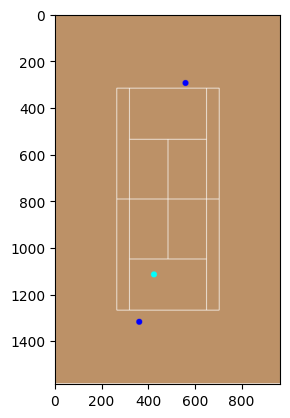

In [62]:

points = float32([[[1050, 900]]])
transformed = perspectiveTransform(points, M)[0][0]
circle(processedFrame, (int(transformed[0]), int(transformed[1])), radius=0, color=(0, 255, 255), thickness=25)

plt.imshow(processedFrame);

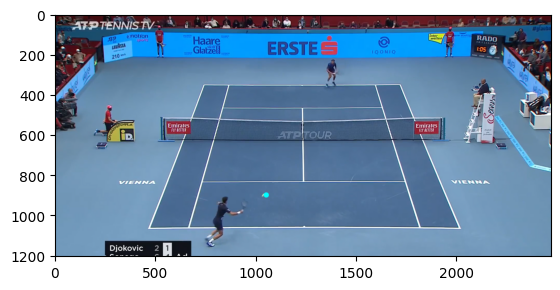

In [63]:
circle(img, (1050, 900), radius=0, color=(0, 255, 255), thickness=25)
plt.imshow(img);

In [64]:
import math

def euclideanDistance(point1, point2):
    return math.dist(point1, point2)

def withinCircle(center, radius, point):
    return radius > euclideanDistance(center, point)

def closestPoint(prevCenter, currCenter, prevPoint, currPoint):
    if euclideanDistance(prevCenter, prevPoint) <= euclideanDistance(currCenter, currPoint):
        return True

In [ ]:
img_ = img.copy()

ball = [1050, 900]
ballPrev = [1030, 920]

In [ ]:
# Calculate euclidian distance between average of feet and hand indexes for both players
circleRadiusBody1 = int(0.65 * euclideanDistance(nosePoints[0], [body1.x, body1.y]))
circleRadiusBody2 = int(0.6 * euclideanDistance(nosePoints[1], [body2.x, body2.y]))

In [ ]:
if ball is not None:
    circle(img_, ball, 4, (0,255,0), 3)
    circle(img_, ballPrev, 3, (0,255,0), 2)
    
    # If ball location is unique
    if ball is not ballPrev:
        # Find locations where the ball gets closer to the body
        if withinCircle(handPoints[1], circleRadiusBody1, ball):
            if minDist1>euclideanDistance(handPoints[1], ball):
                minDist1 = euclideanDistance(handPoints[1], ball)
                coords.append((ball, givePoint(M, ball), givePoint(M, (body1.x,body1.y)), counter))
        else:
            minDist1 = circleRadiusBody1
        if withinCircle(handPoints[3], circleRadiusBody2, ball):
            if minDist2>euclideanDistance(handPoints[3], ball):
                minDist2 = euclideanDistance(handPoints[3], ball)
                coords.append((ball, givePoint(M, ball), givePoint(M, (body2.x,body2.y)), counter))
        else:
            minDist2 = circleRadiusBody2

        # Find locations of ball bounce
        if ball_detector.xy_coordinates[-2][0] is not None:
            xVelocity = ball[0] - ballPrev[0]
            yVelocity = (ball[1] - ballPrev[1])*(1+(height-ball[1])*0.4/height)
            if withinCircle(handPoints[3], circleRadiusBody2, ball) or withinCircle(handPoints[1], circleRadiusBody1, ball):
                within = True
            else:
                within = False
            velocities.append(([xVelocity,yVelocity], counter, givePoint(M, ball), within))
                

# If the previous ball coordinate is close to the current one, remove the previous one
if len(coords)>=2:
    if euclideanDistance(coords[-1][0], coords[-2][0]) < 200:
        del coords[-2]

# Display hit points
for i in range(len(coords)):
    circle(img_, coords[i][0], 4, (0,0,255), 4)

[(745, 350), (1720, 350), (470, 1070), (2010, 1060)]

In [ ]:
def convert_pixel_distance_2_meters(pixel_distance, 
                           reference_height_in_meters, 
                           reference_height_in_pixel):
    """Cross multiplication
    20 --> 10.97
    """
    # pixel_distance - Дикты в листе
    # reference_height_in_meters - лист из диктов
    # reference_height_in_pixel - Лист из тензоров  
    return (pixel_distance * reference_height_in_meters) / reference_height_in_pixel

def convert_meters_2_pixel_distance(meters, 
                                    reference_height_in_meters, 
                                    reference_height_in_pixels):
    return (meters * reference_height_in_pixels) / reference_height_in_meters

In [ ]:
# USE THIS
# https://github.com/yastrebksv/TennisCourtDetector